## Libraries

In [1]:
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import momepy
import os
import networkx as nx
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Helper functions

In [2]:
# nodes_type_list is list of tuples of form [(nodes_df, node_color, node_label)]
def plot_nodes_and_edges(node_type_list, edges_df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    edges_df.plot(ax=ax, color = 'darkgray', zorder=1, label='edges')
    for n in node_type_list:
        n[0].plot(ax=ax, color = n[1], label = n[2], zorder=2)
    ax.legend()
    return ax

In [3]:
# add a column for the node's position in the form used by networkx. 
# note: this is only useful when converting from geopandas df to networkx graph
def nx_pos(x, y):
    return {'pos': (x,y)}

In [4]:
# convert from gpd df to networkx graph object
# input: df of nodes
# output: networkx graph with nodes and positions. note: edges still need to be added to complete the graph structure
def to_nx_graph(nodes_df):
    graph_nodes = list(zip(nodes_df.ID.tolist(), nodes_df.nx_pos.tolist()))
    G = nx.DiGraph()
    G.add_nodes_from(graph_nodes)
    return G

In [5]:
# prune the edges of the edge df
# eliminates edges that connect nodes which are not members of the graph
# return graph edges in the proper form, ready to be added to the networkx graph
def prune_edges(G, edges_df):
    edges_df_subset = edges_df[(edges_df['N1'].isin(G.nodes)) & (edges_df['N2'].isin(G.nodes))]
    graph_edges = list(zip(edges_df_subset['N1'].tolist(), edges_df_subset['N2'].tolist(),
                       edges_df_subset['attr'].tolist()))
    return graph_edges

In [6]:
def nx_edge_attr(linkID, speed):
    attr_dict = {'linkID': linkID, 'speed':speed}
    return attr_dict

In [7]:
def nx_edge_attr(attr_name, attr_var):
    return {attr_name: attr_var}

In [8]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [60]:
def relabel_nodes(G, prefix):
    new_nodename = [prefix+str(i) for i in G.nodes]
    namemap = dict(zip(G.nodes, new_nodename))
    G = nx.relabel_nodes(G, namemap, True)
    return G

In [66]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
# input: single point, multipoint (collection of many nodes)
# output: the node in multipoint that is nearest to the input single point
def near(input_point, multipoint):
    nn = nearest_points(input_point, multipoint)[1]  # returns the nn point as a geometry
    dist = input_point.distance(nn)  # nearest neighbor distance 
    return (nn, dist)

In [9]:
def draw_graph(G, node_color, node_cmap):
    # draw the graph in networkx
    node_coords = nx.get_node_attributes(G, 'pos')    
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw(G, pos=node_coords, with_labels=True, font_color='white', font_size=8,  font_weight = 'bold',
            node_size=500, node_color=node_color, edge_color='gray', arrowsize=16, ax=ax)
    # add legend for node color    
    inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
    for v in set(inv_node_cmap.keys()):
        ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'upper right')
    return ax

## Pittsburgh Road Network Data

In [10]:
cwd = os.getcwd() 

In [11]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/SPC_GIS/')
os.chdir(new_dir)

In [12]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [13]:
nodes = read_file("new_node.shp")
edges = read_file("new_link.shp")

In [14]:
nodes.head(3)
len(nodes)
edges.head(3)
len(edges)

,ID,isOD,geometry
0,1,0,POINT (-79.83845 40.54487)
1,3,0,POINT (-80.03123 40.45891)
2,4,0,POINT (-79.06545 40.53644)


6014

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,8290,1,2114,25,1,0.04,0,8290,1388147.792,448212.542,1387767.306,449855.597,"LINESTRING (1388147.792 448212.542, 1388478.88..."
1,8291,1,5550,25,1,0.02,0,8291,1388147.792,448212.542,1388249.875,447637.094,"LINESTRING (1388147.792 448212.542, 1388135.13..."
2,1008267,1,1767,35,2,0.06,0,1008267+8266,1388147.792,448212.542,1387621.732,446190.858,"LINESTRING (1388147.792 448212.542, 1387932.01..."


16110

<AxesSubplot:>

<AxesSubplot:>

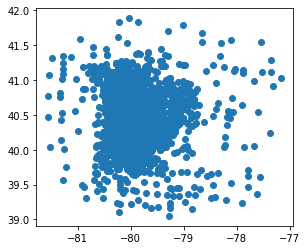

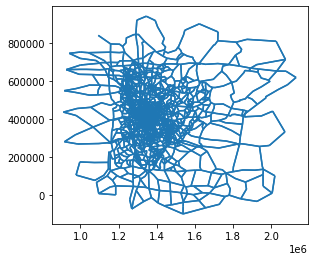

In [17]:
nodes.plot()
#nodes.crs
edges.plot()

## "Clip" the data: subset PGH road network by selected neighborhoods

In [18]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)

<AxesSubplot:>

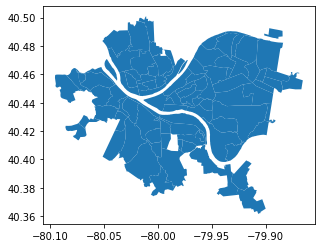

In [19]:
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
pgh_nhoods.plot()  # this is a polygon layer

In [20]:
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
#hood_keep = [ 'Central Oakland', 'North Oakland']  # smaller list for testing
hood_keep = ['Squirrel Hill North', 'Shadyside', 'East Liberty', "Central Oakland", 'North Oakland', 'South Oakland', 'Bloomfield', 'Garfield', 'Friendship', 'East Liberty', 
              'Larimer', 'Shadyside', 'Squirrel Hill North', 'Squirrel Hill South', 'Greenfield', 'Hazelwood', 
              'Glen Hazel'] #'Westwood', 'Crafton Heights', 'Sheraden', 'Windgap', 'Fairywood']
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer

226

<AxesSubplot:>

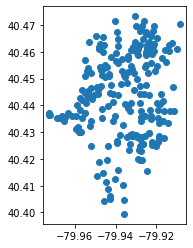

In [21]:
# clip the nodes: only include those within the selected neighborhoods
nodes_clip = gpd.clip(nodes, pgh_nhoods_mask)  
len(nodes_clip)
nodes_clip.plot()

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

680

<AxesSubplot:>

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.250,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.250,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.250,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."
117,1002803,59,1594,25,1,0.02,0,1002803,1362395.028,412111.181,1362391.556,410951.458,"LINESTRING (-79.92789 40.44410, -79.92780 40.4..."
118,1003119,59,187,25,1,0.02,0,1003119,1362395.028,412111.181,1361484.611,412697.323,"LINESTRING (-79.92789 40.44410, -79.93121 40.4..."


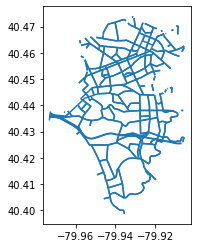

In [22]:
# The geometry of edges has a diferent coordinate ref system than the geometry of nodes and neighborhoods
# edges.crs
# pgh_nhoods_mask.crs
# nodes.crs

# Transform geometry of edges to the proper coord system
edges = edges.to_crs(epsg = 4326)
edges.crs

# Now edges can be clipped appropriately
edges_clip = gpd.clip(edges, pgh_nhoods_mask)
len(edges_clip)
edges_clip.plot()
edges_clip.head(5)

<AxesSubplot:>

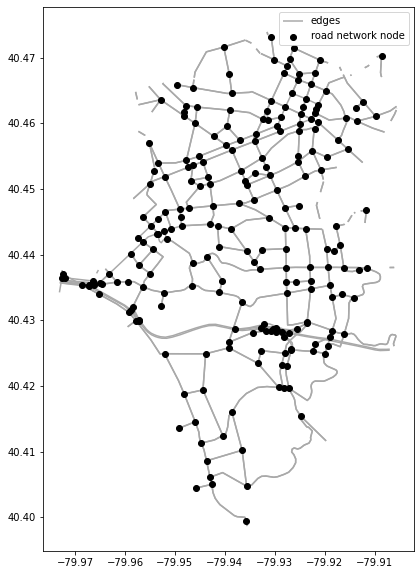

In [23]:
plot_nodes_and_edges([(nodes_clip, 'black', 'road network node')], edges_clip)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.25,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.25,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.25,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."


<AxesSubplot:>

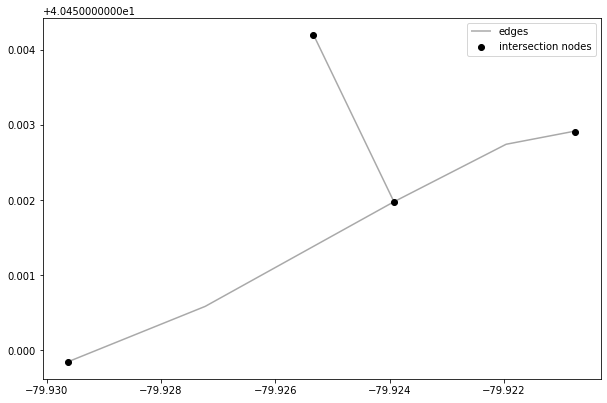

In [24]:
# Are 'N1' and 'N2' in edges df equivalent to 'ID' in nodes df? Test:
edges_clip = edges_clip.astype({'N1':'int32', 'N2':'int32'})
eclip_test = edges_clip[edges_clip['N1'] == 37]
eclip_test
nclip_test = nodes_clip[((nodes_clip['ID'] == 37) | (nodes_clip['ID'] == 3461) | (nodes_clip['ID'] == 2894) | (nodes_clip['ID'] == 727))]

plot_nodes_and_edges([(nclip_test, 'black', 'intersection nodes')], eclip_test)
# this plot confirms that N1 and N2 columns in edges df are equivalent to ID column in nodes df

In [25]:
nodes_clip.loc[27]['geometry'].x
nodes_clip.loc[27]['geometry'].y

-79.923923

40.451967

## Convert geopandas df to networkx graph
### Because the small network test code was written using the networkx graph object

In [26]:
nodes_clip.columns

Index(['ID', 'isOD', 'geometry'], dtype='object')

In [27]:
# add x-y columns for coordinates 
nodes_clip['x'] = nodes_clip.apply(lambda p: p['geometry'].x, axis=1)
nodes_clip['y'] = nodes_clip.apply(lambda p: p['geometry'].y, axis=1)
nodes_clip['nx_pos'] = nodes_clip.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
nodes_clip.columns

Index(['ID', 'isOD', 'geometry', 'x', 'y', 'nx_pos'], dtype='object')

In [28]:
nodes_clip.head(3)

,ID,isOD,geometry,x,y,nx_pos
27,37,0,POINT (-79.92392 40.45197),-79.923923,40.451967,"{'pos': (-79.923923, 40.451967)}"
42,59,0,POINT (-79.92788 40.44410),-79.927882,40.444097,"{'pos': (-79.927882, 40.444097)}"
46,68,0,POINT (-79.95212 40.44356),-79.952119,40.443561,"{'pos': (-79.952119, 40.443561)}"


In [29]:
# add nodes to the graph, including their positions 
G_base = to_nx_graph(nodes_clip)
G_base.nodes[37]['pos']
edges_clip.head()

(-79.923923, 40.451967)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.250,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.250,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.250,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."
117,1002803,59,1594,25,1,0.02,0,1002803,1362395.028,412111.181,1362391.556,410951.458,"LINESTRING (-79.92789 40.44410, -79.92780 40.4..."
118,1003119,59,187,25,1,0.02,0,1003119,1362395.028,412111.181,1361484.611,412697.323,"LINESTRING (-79.92789 40.44410, -79.93121 40.4..."


In [30]:
edges_clip['nx_speed'] = edges_clip.apply(lambda e: nx_edge_attr('speed', e['spd']), axis=1)
edges_clip['nx_linkID'] = edges_clip.apply(lambda e: nx_edge_attr('link_ID', e['linkID']), axis=1)
edges_clip['attr'] = edges_clip.apply(lambda e: merge(e['nx_speed'], e['nx_linkID']), axis=1)
edges_clip.head()

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,nx_speed,nx_linkID,attr
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.250,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4...",{'speed': '25'},{'link_ID': '1003090'},"{'speed': '25', 'link_ID': '1003090'}"
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.250,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4...",{'speed': '20'},{'link_ID': '1003094'},"{'speed': '20', 'link_ID': '1003094'}"
77,3097,37,727,25,2,0.02,0,3097,1363567.250,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4...",{'speed': '25'},{'link_ID': '3097'},"{'speed': '25', 'link_ID': '3097'}"
117,1002803,59,1594,25,1,0.02,0,1002803,1362395.028,412111.181,1362391.556,410951.458,"LINESTRING (-79.92789 40.44410, -79.92780 40.4...",{'speed': '25'},{'link_ID': '1002803'},"{'speed': '25', 'link_ID': '1002803'}"
118,1003119,59,187,25,1,0.02,0,1003119,1362395.028,412111.181,1361484.611,412697.323,"LINESTRING (-79.92789 40.44410, -79.93121 40.4...",{'speed': '25'},{'link_ID': '1003119'},"{'speed': '25', 'link_ID': '1003119'}"


In [31]:
# only include edges if the nodes they connect are also in the nodes of the graph
graph_edges = prune_edges(G_base, edges_clip)
graph_edges[:3]

[(37, 3461, {'speed': '25', 'link_ID': '1003090'}),
 (37, 2894, {'speed': '20', 'link_ID': '1003094'}),
 (37, 727, {'speed': '25', 'link_ID': '3097'})]

In [32]:
# add edges to the graph, including their ID and speed limit
G_base.add_edges_from(graph_edges)
len(G_base.nodes)

226

Text(0.5, 1.0, 'Base Road Map for Selected Neighborhoods')

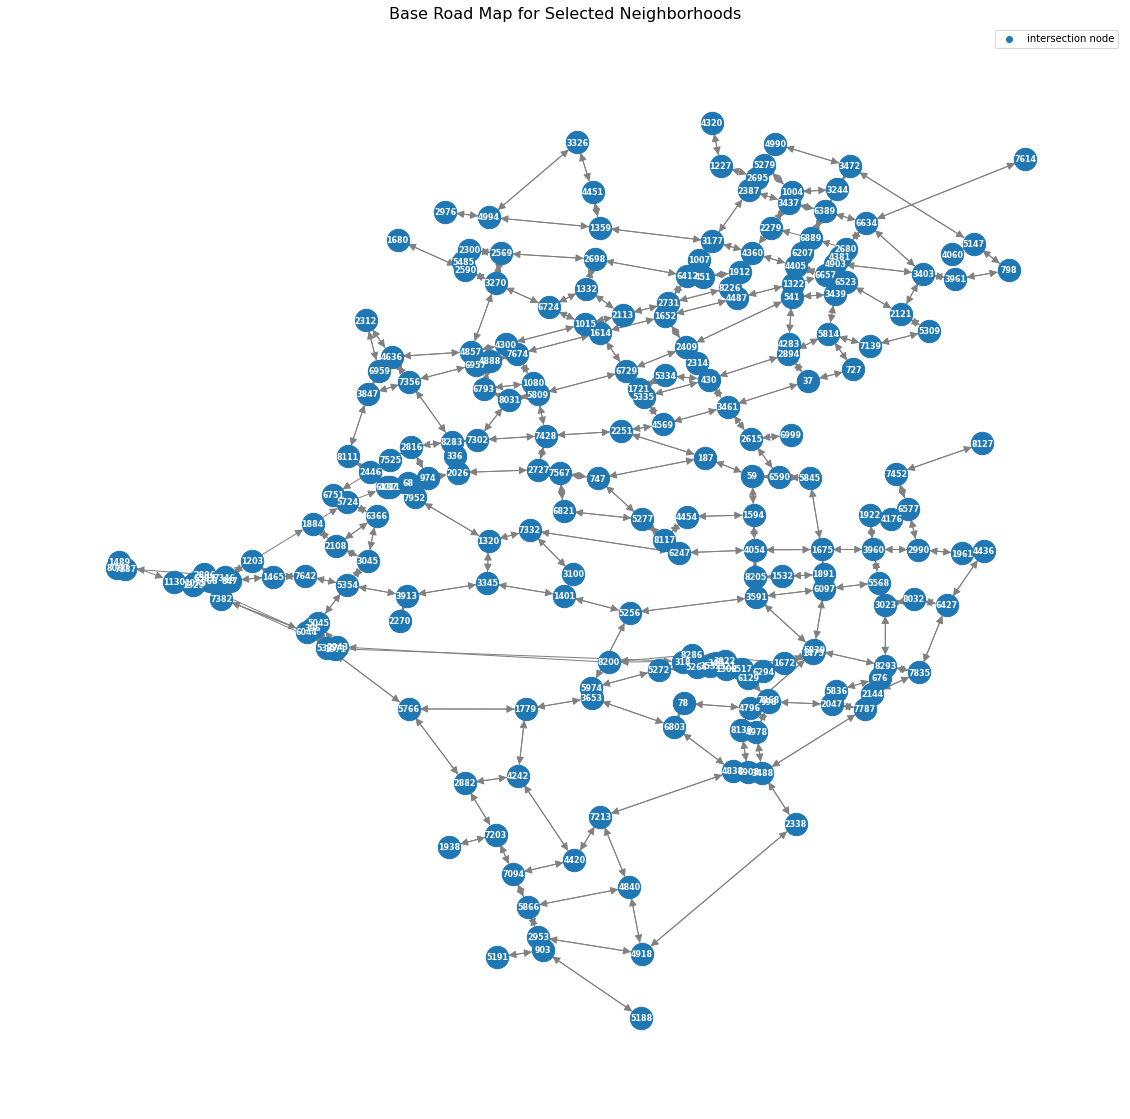

In [33]:
node_cmap = {'intersection node': '#1f77b4'}
ax = draw_graph(G_base, '#1f77b4', node_cmap)
ax.set_title('Base Road Map for Selected Neighborhoods', fontsize=16)

## TNC
The TNC graph is assumed to be the same as the base road network

In [56]:
G_tnc = G_base.copy()
G_tnc = relabel_nodes(G_tnc, 't')

## Personal Vehicle 

### Park and Ride Data

In [61]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/ParkRide')
os.chdir(new_dir)
file_name = 'SPCRegPNR.shp'   # https://data.wprdc.org/dataset/regional-park-n-ride-facilities-web-inventory/resource/46692b9c-ad3f-4a29-8deb-5ca4207eb50d
pnr_gdf = read_file(file_name)
pnr_gdf.head(2)
#pnr_gdf.crs
# Transform geometry of edges to the proper coord system
pnr_gdf = pnr_gdf.to_crs(epsg = 4326)
#pnr_gdf.crs

,ID,STATUS,NAME,LOCATION,MUNIC,ZIPCITY,ZIPCODE,COUNTY,X_COORD,Y_COORD,RESTRICT_,CAPACITY,OWNER,PARK_FEE,D_PARK_FEE,M_PARK_FEE,SERV_TRANS,TRANS_OP_1,TRANS_OP_2,geometry
0,1.0,OPEN,OLYMPIA SHOPPING CENTER-WALNUT ST-MCKEESPORT,4313 WALNUT ST.,CITY OF MCKEESPORT,MCKEESPORT,15132,ALLEGHENY,40.32270,-79.83461,TRANSIT ONLY,50,PRIVATE,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1387303.979 367272.753)
1,2.0,OPEN,DUQUESNE-LIBRARY PL AT DUQUESNE BLVD-DUQUESNE,RT 837 (DUQUESNE BLVD.) AT LIBRARY PL.,CITY OF DUQUESNE,DUQUESNE,15110,ALLEGHENY,40.37227,-79.84466,NONE,311,PORT AUTHORITY OF ALLEGHENY COUNTY,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1384930.811 385392.023)


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

(0, 20)

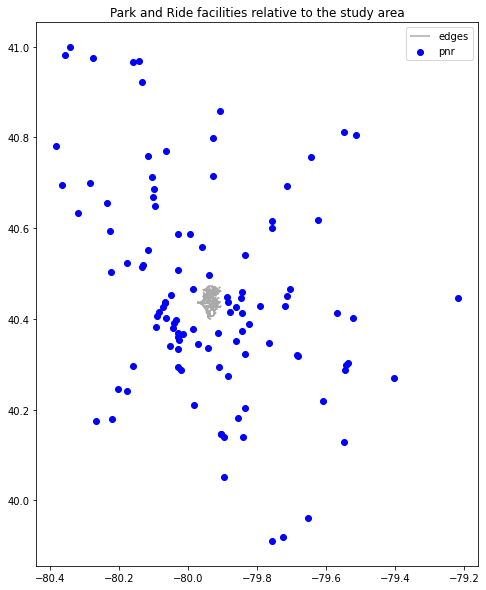

In [62]:
ax = plot_nodes_and_edges([(pnr_gdf, 'blue', 'pnr')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
# observe that no park and ride facilities intersect the study area...
# confirmation:
pnr_clip = gpd.clip(pnr_gdf, pgh_nhoods_mask)
pnr_clip.shape

Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

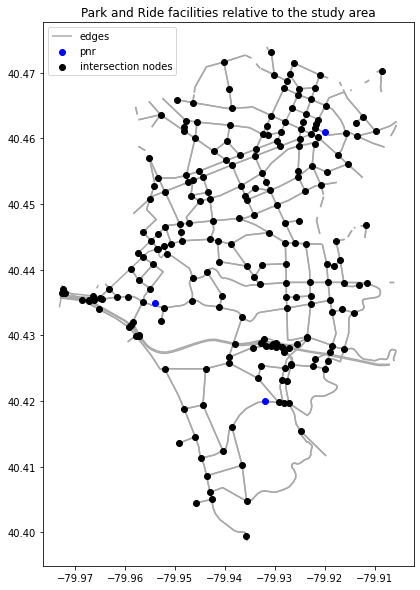

In [63]:
# for testing, i have chosen to create three fake pnr facilities located within study area
# randomly choose three nodes that are spead out in the road network
pnr1 = (-79.954, 40.435)
pnr2 = (-79.92, 40.461)
pnr3 = (-79.932, 40.42)
pnr_coords = [pnr1, pnr2, pnr3]
# build Points from these coords
point_list = [Point(c[0], c[1]) for c in pnr_coords]
new_pnr_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(point_list))
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')

### Create edges from Park and Ride stations to nearest node neighbor in the road network

In [67]:
# find the intersection node in the road network that is nearest to the pnr station
new_pnr_gdf['nn'] = new_pnr_gdf.apply(lambda row: near(row['geometry'], nodes_clip.geometry.unary_union)[0], axis=1)
new_pnr_gdf
# add linestring beween each pnr facility and its nn
pnr_edges = [LineString([row['geometry'], row['nn']]) for i, row in new_pnr_gdf.iterrows()]
pnr_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(pnr_edges))

# these edges will be explicitly added to the networkx graph structure

,geometry,nn
0,POINT (-79.95400 40.43500),POINT (-79.95222099999999 40.434248)
1,POINT (-79.92000 40.46100),POINT (-79.9213 40.460154)
2,POINT (-79.93200 40.42000),POINT (-79.929237 40.419784)


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

<AxesSubplot:title={'center':'Park and Ride facilities relative to the study area'}>

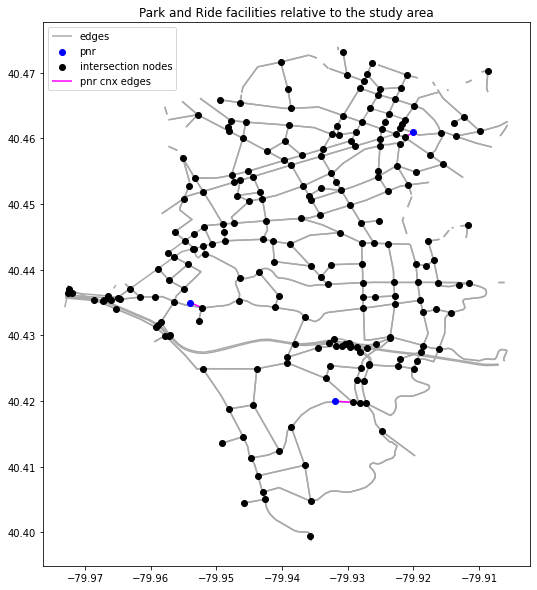

In [68]:
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
pnr_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='pnr cnx edges')
ax.legend()

### Convert to networkx graph object

In [69]:
# create graph structure 
# start with base road network
G_pv = G_base.copy()
G_pv = relabel_nodes(G_pv, 'pv')

In [81]:
# add PNR stations and edges
new_pnr_gdf['x'] = new_pnr_gdf['geometry'].x
new_pnr_gdf['y'] = new_pnr_gdf['geometry'].y
new_pnr_gdf['nx_pos'] = new_pnr_gdf.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
#new_pnr_gdf.insert(loc=0, column='ID', value=np.arange(len(new_pnr_gdf)))
G_pnr = to_nx_graph(new_pnr_gdf)
G_pnr = relabel_nodes(G_pnr, 'k')

In [84]:
# merge the road network with the pnr stations
#G_pv = nx.union_all([G_pv, G_pnr])
# add edges from pnr station to the road map in order to connect the network
new_pnr_gdf
# next step: find the node ID of nn. need to join with original node df, then back out ID

,ID,geometry,nn,x,y,nx_pos
0,0,POINT (-79.95400 40.43500),POINT (-79.95222099999999 40.434248),-79.954,40.435,"{'pos': (-79.954, 40.435)}"
1,1,POINT (-79.92000 40.46100),POINT (-79.9213 40.460154),-79.920,40.461,"{'pos': (-79.92, 40.461)}"
2,2,POINT (-79.93200 40.42000),POINT (-79.929237 40.419784),-79.932,40.420,"{'pos': (-79.932, 40.42)}"


## Bikeshare

**Get bikeshare Data**

In [ ]:
# Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations

In [ ]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
os.getcwd()

In [ ]:
filename = 'pgh_bikeshare_depot_q3_2021.csv'
bs_df = pd.read_csv(filename)
bs_df.head()

In [ ]:
# add position column, to be used when converting to networkx graph object
bs_df['nx_pos'] = bs_df.apply(lambda p: nx_pos(p['Longitude'], p['Latitude']), axis=1)

**Convert to geo df and clip to selected neighborhoods**

In [ ]:
# generate point geometry from x,y coords, so that the GIS clip function can be used to only 
# include depots within the study region
bs_df['geometry'] = gpd.points_from_xy(bs_df.Longitude, bs_df.Latitude, crs="EPSG:4326")
bs_gdf = gpd.GeoDataFrame(bs_df)  # convert to geo df
bs_gdf.plot()

In [ ]:
# Clip the bs node network
bs_depots_clip = gpd.clip(bs_gdf, pgh_nhoods_mask)
bs_depots_clip.plot()

In [ ]:
# Back to the original road network...
# Find the "bike-friendly" streets, i.e. those with a speed limit <= 40
bike_speedlim_max = 40
edges_clip['spd'] = edges_clip['spd'].astype('float')
bike_edges_clip = edges_clip[edges_clip['spd'] <= bike_speedlim_max]
edges_clip.shape
bike_edges_clip.shape  # no reduction in roads with a max speed limit of 40...could lower the max speed limit if desired
# Find the nodes that interesect the bike-friendly streets (in the clipped network)
nodes_keep = list(set(bike_edges_clip.N1.tolist() + bike_edges_clip.N2.tolist()))
bike_nodes_clip = nodes_clip[nodes_clip.ID.isin(nodes_keep)]
bike_nodes_clip.shape
nodes_clip.shape

In [ ]:
plot_nodes_and_edges(bs_depots_clip, edges_clip)

**Approximate the location of a depot node as the location of the network node that is nearest to it**

Snap the bikeshare depots to the nearest nodes in the road network. This is an approximation. <br>
I cannot yet figure out how to snap them to the nearest line. <br>
Other idea to try at some point: 1) find nearest node in the road network relative to the given bikeshare depot. 2) calc distance between depot and node. 3) if dist exceeds some value, find nearest line centroid relative to the given bikeshare depot. 4) choose the closer node: road network node or line centroid. 4) if line centroid is chosen, need to build edges from depot to line start node and depot to line end node <br>
See: gpd.centroid() and gpd.represenative_point()

In [ ]:
# prepare data
bike_nodes_clip['isDepot'] = 'N'  # "isDepot" column: Y if intersection node can be approximated as depot, N o/w
bike_nodes_union = bike_nodes_clip.geometry.unary_union  # returns a multipoint of all nodes

In [231]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
# input: single point, multipoint (collection of many nodes)
# output: the node in multipoint that is nearest to the input single point
def near(input_point, multipoint):
    nn = nearest_points(input_point, multipoint)[1]  # returns the nn point as a geometry
    dist = input_point.distance(nn)  # nearest neighbor distance 
    return (nn, dist)

In [ ]:
# find the intersection node in the bike network that is nearest to the depot
bs_depots_clip['nn'] = bs_depots_clip.apply(lambda row: near(row['geometry'], bike_nodes_union)[0], axis=1)
# map back to original bike network node data and fill the 'isDepot' column
all_nn = gpd.GeoDataFrame(bs_depots_clip['nn'].rename('geometry')).geometry.unary_union  # a multipoint of all nn points
bike_nodes_clip['isDepot'] = bike_nodes_clip.apply(lambda row: 'Y' if all_nn.contains(row['geometry']) else 'N', axis=1)
#all_nn.rename('geometry', inplace=True)
#bike_nodes['isDepot'] = bike_nodes.apply(lambda row: row['geometry']  , axis=1)

In [ ]:
depot_approx = bike_nodes[bike_nodes_clip['isDepot'] == 'Y']
bs_depots_clip.head()
depot_approx.head()

In [ ]:
plot_nodes_and_edges([(bs_depots_clip, 'black','actual depot'), (depot_approx, 'blue', 'approximated depot')],
                      bike_edges_clip)
ax.set_title('Bikeshare Network')

In [ ]:
bike_nodes[bike_nodes['isDepot'] == 'Y'].shape
bike_nodes_clip.head()

In [ ]:
bike_nodes_clip['nx_isDepot'] = bike_nodes_clip.apply(lambda p: nx_attr('isDepot', p['isDepot']), axis=1)

In [ ]:
G_bs = to_nx_graph(bike_nodes_clip)
nx.set_node_attributes(G_bs, dict(zip(bike_nodes_clip['ID'].tolist(), bike_nodes_clip['nx_isDepot'].tolist())))
G_bs.nodes[37]

In [ ]:
# only include edges if the nodes they connect are also in the nodes of the graph
G_bs_edges = prune_edges(G_bs, bike_edges_clip)
G_bs.add_edges_from(G_bs_edges)

In [ ]:
node_color = ['black' if depot == 'N' else 'blue' for depot in nx.get_node_attributes(G_bs, 'isDepot').values()]
node_cmap = {'intersection node':'black', 'depot node':'blue'}
draw_graph(G_bs, node_color, node_cmap)

In [ ]:
# Note that in the figure of nodes_clip and edges_clip, there are some detached roads. Let's only include a fully connected network
nodes_included = nodes_clip['ID'].tolist()
node_mask = edges_clip['N1'].isin(nodes_included) | edges_clip['N2'].isin(nodes_included)
new_edges_clip = edges_clip[node_mask]
len(new_edges_clip)
plot_nodes_and_edges(nodes_clip, new_edges_clip)